## Pairing of Lecturers and students for the ABB Tutored dissertations

This notebook takes the spreadsheet `lecturers.xlsx` and the spreadsheet `students.xlsx` and performs the matches to find a tutor and an examinar for each student. The matchings are performed by maximizing the overlap among a set of topics. Each lecturer is assigned at least 2 topics of interes for which they can provide supervision in a tutored dissertation. Similarly the students select in order 3 topics of interest.

The matching algorithm attempts to maximize the score function

$L = \sum_{\{s,t,e\}} \langle \vec \sigma_s, \vec \phi_t \rangle + \lambda \langle \vec \sigma_s,\vec \phi_t,\vec \phi_e \rangle + \beta \langle \vec \phi_t,\vec \phi_e \rangle + \eta (\tau_t + \epsilon_e) $

Where the sum runs over all the proposed triplets ${\{s,t,e\}}$ of student/tutor/examiner (Note that there might be extra lecturers). The 5 terms of the score function, score correspondingly: 1) The alignment of interest between student and tutor, 2) The alignment of interest between student/tutor/examiner and 3) the alignment of interest between examiner/tutor (trying to assign buddies to avoid examining projects that are too far of expertise) 4) Assignment of the preferred role to the lecturer.   The function contains the following elements:

- The vectors $\vec \sigma$ contains the preferences of each student for the ordered set of topics, the vector is constructed so $\sigma_i=1$ for the top favourite topic, and $\sigma_i=-1$ for the least favourite topic ($\sum \sigma_i = 0$).
- Similarly the vectors $\vec \phi$ contain the topics of the lecturers that are encoded in the format  e.g. $\vec \phi = (0,0,f,f,0,0,0,0,f)$, where $f$ is defined so $||\vec\phi||=\sum f^2=1$.
- The constant $\lambda>0$ favours triplets with overlap of interests (Note that the triple scalar product $\langle a,b,c \rangle$ is only non-zero when there is an overlap in at least 1 category among the 3 individual).
- Finally the constant $\beta>0$ is the 'buddy' constant, maximizing the number of areas of interest between tutor/examiner.
- The weights $\tau$ (tutor) and $\epsilon$ (examiner) promote/penalize particular roles for particular lecturers. By default $\tau=\epsilon=1$ for every lecturer. These can be controlled for example to avoid a lecturer repeating a tutor role two years in a row by setting $\tau=0.1$ for that lecturer. The relevance of the weights in the final score is controlled through the parameter $\eta$

The triplet list is inititialized with a greedy algorith, that assigns tutors and examiners with at least one are of interest in common. After that a simulated annealing strategy is used to improve the initial proposal, maximizing the score $L$

### Loading and formatting data

In [4]:
import pandas as pd
import numpy as np
import random as random
import matplotlib.pyplot as plt
from tqdm import tqdm

# Importing the lectuers data
file_lecturers = 'Lecturers.xlsx'
df_lecturers = pd.read_excel(file_lecturers)

# remove non-SK lecturers
df_lecturers = df_lecturers[df_lecturers['Location']=='SK']
df_lecturers.index = range(0,len(df_lecturers)) # reindex so first index is 0

print('SK Lecturers spreadhseet read successfully:   \n',df_lecturers.head(10))

topics = ['Neurobiology','Cell and Developmental Biology',
        'Malaria and other Infectious Diseases','Cancer Biology and Immunology',
        'Bioinformatics and Computational Biology','Biophysics',
        'Plant Science','Microbiology','Synthetic Biology',
        'Structural Biology and Protein Science']


preferred_roles_diclist = {'Examiner':[0.2,1.0],'Tutor':[1.0,0.2],
                           'Extra':[0.0,0.1],'Neutral':[1.0,1.0]} # values of ε and τ for each preferred role
N_topics = len(topics)

def encode_row_lecturer(row): # encoding topics in the vector format Φ
    econded_row = np.array([1 if row[col] == 'X' else 0 for col in topics])
    return econded_row/np.sqrt(np.sum(econded_row*econded_row)) # normalized so lecturers with less topics are not penalized in pairings


lecturers_list = [] # list with the encoded interests for each lecturer 
lecturers_prole = [] # list with the encoded preferred roles for each lecturer 
for irow, row in df_lecturers.iterrows():
    lecturer_interest = encode_row_lecturer(row)
    lecturers_list.append(lecturer_interest)
    lecturers_prole .append(preferred_roles_diclist[row['Preferred role']])
    string_interests = ','.join([topics[itopic] for itopic,topic in enumerate(lecturer_interest) if topic>0])
    df_lecturers.loc[irow,'Interests'] = string_interests  
N_lecturers = len(lecturers_list)    

print('Encoding {} lecturers successfully, e.g.'.format(N_lecturers), lecturers_list[0])

# Importing the students data
# at the moment synthetically created

file_students = 'students.xlsx'
df_students = pd.read_excel(file_students)

df_students.index = range(0,len(df_students)) # reindex so first index is 0
print('Students spreadhseet read successfully:   \n',df_lecturers.head(10))

def encode_row_student(row): # encoding topics in the vector format Φ
    topics_string = row['Please rank the following project topics by dragging your most preferred topics at the top and your least preferred topics at the bottom.']
    topics_student = topics_string.split(';')
    topics_student = np.array([topics_student.index(topic) for topic in topics])
    topics_student = 2*(N_topics-1-topics_student)/(N_topics-1)-1 # normalizing student choices to [-1,1]
    return topics_student,topics_string

students_list = []
for irow, row in df_students.iterrows():
    student_interest,string_interest = encode_row_student(row)
    students_list.append(student_interest)
    print('student', student_interest)
    #string_interests = ','.join([topics[itopic] for itopic,topic in enumerate(student_interest) if topic>0])
    df_students.loc[irow,'Interests'] = string_interest 
N_students = len(students_list)    

    
#Cleaning dataFrames of unused columns
df_students = df_students[['Name','Surname','Imperial College e-mail address','Interests']]
df_lecturers = df_lecturers[['First Name','Last Name','Email address','Interests','Preferred role']]
 
print('Encoding {} students successfully, e.g. {}'.format(N_students,students_list[0]))

SK Lecturers spreadhseet read successfully:   
       Department Last Name First Name    Email address      Grade  \
0  Life Sciences     Name2   Surname2  email2@ic.ac.uk     Reader   
1  Life Sciences     Name3   Surname3  email1@ic.ac.uk  Professor   
2  Life Sciences     Name5   Surname5  email1@ic.ac.uk     Reader   
3  Life Sciences     Name6   Surname6  email2@ic.ac.uk   Lecturer   
4  Life Sciences     Name7   Surname7  email1@ic.ac.uk     Reader   
5  Life Sciences     Name8   Surname8  email2@ic.ac.uk     Reader   
6  Life Sciences    Name11  Surname11  email1@ic.ac.uk     Reader   
7  Life Sciences    Name12  Surname12  email2@ic.ac.uk  Professor   
8  Life Sciences    Name14  Surname14  email2@ic.ac.uk     Reader   
9  Life Sciences    Name15  Surname15  email1@ic.ac.uk  Professor   

  Preferred role Location Neurobiology Cell and Developmental Biology  \
0        Neutral       SK          NaN                            NaN   
1        Neutral       SK          NaN        

### Greedy initialization

The greedy algorithm starts assigning tutors students starting from the least popular topics from students independent of order of preference among students. Then performs the same tasks to assign examiners from the remaining lecturers. The examiners are chosen to first overlap interests with student and tutor. If not possible, then an examiner is chosen that shares at least 1 area of interest with tutor

In [5]:
# Greedy algorithm for the preliminary choice:
# First we choose the tutors as the best choice for each student ranked from rare to common
# this will ensure that we attempt to populate all the topics

free_students = list(range(N_students))
free_lecturers = list(range(N_lecturers))
free_lecturers = sorted(free_lecturers, key = lambda x: lecturers_prole[x][0],reverse = True) # order list to put preferred examiners frist

pairing = np.zeros((N_students,3),dtype=int)

topic_counts = np.sum(np.array(students_list)>0,axis=0) # count for each topic how many it recieves a positive score

print("Assigning main tutors....")

ipairing = 0

for topic in np.argsort(topic_counts):
    #print("-"*10)
    #print("Left students {}, assigning topic {}: {}\n".format(len(free_students),topic,topics[topic]))
    for student in free_students[:]:
       # print(students_list[student][topic])
        if students_list[student][topic]>0:
            for lecturer in free_lecturers[:]:
                if lecturers_list[lecturer][topic]>0:
                    pairing[ipairing,:] = [student,lecturer,0]
                    ipairing = ipairing + 1
                    free_students.remove(student)
                    free_lecturers.remove(lecturer)
                    #print('## student: ',df_students.iloc[student])
                    #print('\n')
                    #print('## lecturer: ',df_lecturers.iloc[lecturer])
                    #print('\n'*2)
                    break
print('Found {} suitable tutors!'.format(ipairing))
# once we ran out of topics, there might be some people without topic, we reasign those

if len(free_students)>0:
    print('Assigning {} tutors that are out of the expertise'.format(N_students-len(free_students)))
    while len(free_students>0):
        student = free_students.pop()
        lecturer = free_lecturers.pop()
        pairing[ipairing,:] = [student,lecturer,0]
        ipairing = ipairing + 1        

print("\nAssigning examiners ....")
ipairing = 0
free_students = list(range(N_students)) # all students are free of examiners, but lecturers is kept to avoid overloading teachers

for ipair,pair in enumerate(pairing): # for each pairing we look for a suitable examiner
    common_topics = np.nonzero((students_list[pair[0]] != 0) & (lecturers_list[pair[1]] != 0))[0] # common topics for the 3 people
    sorted_common_topics = sorted(common_topics, key = lambda x: topic_counts[x]) # to assign examiners of rarer topics
    buddy_topics = np.nonzero((students_list[pair[0]] == 0) & (lecturers_list[pair[1]] != 0))[0] # common topics among lecturers
    sorted_buddy_topics = sorted(buddy_topics, key = lambda x: topic_counts[x]) # to assign examiners of rarer topics
    sorted_topics = np.concatenate((sorted_common_topics,sorted_buddy_topics)).astype(int)
    # print("Assigning examiner to student: ",students_list[pair[0]])
    # print("with tutor: ",df_lecturers.iloc[pair[1]])
    # print("and topic list: ", [topics[t] for t in sorted_topics])
    for topic in sorted_topics:
        for lecturer in free_lecturers[:]:
            # print('evaluating topic {} /lecturer {} \n that has topics {}'.format(
                # topics[topic],df_lecturers.loc[pair[1],'Last Name'],
                # df_lecturers.loc[pair[1],'Interests']))            
            if lecturers_list[lecturer][topic]>0:
                # print('Tutor accepted!')
                pairing[ipair,2] = lecturer
                free_students.remove(pair[0])
                free_lecturers.remove(lecturer)
                break                
        else: continue # if no lecturer found then continue to next topic
        break # if lecturere found (else not triggered) then exit outer loop as well  

print('Found {} suitable examiners!'.format(N_students - len(free_students)))

if len(free_students)>0:
    print('Assigning {} examiners that are out of the expertise'.format(free_students))
    for student in free_students[:]: # for each remaining student without examiner
        pair_index = np.argmax(pairing[:, 0] == student)
        #print('student, index', student, pair_index)
        pairing[pair_index][2] = free_lecturers.pop()
        free_students.remove(student)
        
print ("Finished pairing! The unassigned lecturers where: {}".format(free_lecturers))
        

# storing the results in a new dataframe. First we will generate dataframes for students/tutor/examiners with the information required
# then we will concatenate them in the right order

df_students_prefix = df_students.add_prefix('student ')
df_tutors_prefix = df_lecturers.add_prefix('tutor ')
df_examiners_prefix = df_lecturers.add_prefix('examiner ')
        
pairing_df = [pd.concat([df_students_prefix.iloc[i], df_tutors_prefix.iloc[j], df_examiners_prefix.iloc[k]]) for i,j,k in pairing]
pairing_df = pd.DataFrame(pairing_df).reset_index(drop=True)
pairing_df.head()
pairing_df.to_csv('preliminary_pairing.csv', index=False)

pairing_greedy = pairing[:]
free_lecturers_greedy = free_lecturers[:]


Assigning main tutors....
Found 33 suitable tutors!

Assigning examiners ....
Found 30 suitable examiners!
Assigning [0, 4, 7] examiners that are out of the expertise
Finished pairing! The unassigned lecturers where: [50, 64, 17, 34, 47, 56, 61]


### Simulated annealing

The initial proposal obtained by the greedy algorithm is improve by simulated annealing

There are NO duplicates in the greedy pairing
No duplicates found.
scores:  3.0826685484284773 0.6666666666666669 1.0000000000000002
scores:  4.0070787221094175 0.4999999999999999 0.4999999999999999
scores:  2.9991822985688095 0.4999999999999999 0.4999999999999999
scores:  4.031471149485698 0.816496580927726 0.816496580927726
scores:  3.4590808870717 0.7071067811865475 0.7071067811865475
scores:  2.117851130197758 0.7071067811865475 0.7071067811865475
scores:  2.968034511247708 0.35355339059327373 0.35355339059327373
scores:  2.8806466108376845 0.408248290463863 0.816496580927726
scores:  2.5130571579191336 0.35355339059327373 0.7071067811865475
scores:  2.897603013860688 0.4999999999999999 0.4999999999999999
scores:  3.7770652634641912 0.3333333333333334 0.6666666666666669
scores:  2.1484207152918784 0.0 0.4999999999999999
scores:  2.897603013860688 0.4999999999999999 0.4999999999999999
scores:  3.8499438818457405 0.4999999999999999 0.4999999999999999
scores:  3.877251575570443 0.8164

  4%|▍         | 414/10000 [00:00<00:02, 4131.48it/s]

scores:  2.5130571579191336 0.35355339059327373 0.7071067811865475
scores:  2.897603013860688 0.4999999999999999 0.4999999999999999
scores:  2.9612944921610613 0.0 0.35355339059327373
scores:  1.9420474583051321 0.4999999999999999 0.4999999999999999
scores:  1.2 0.0 0.0
scores:  1.2 0.0 0.0
scores:  2.953158569416243 0.4999999999999999 0.4999999999999999
scores:  3.8499438818457405 0.4999999999999999 0.4999999999999999
scores:  2.3142696805273544 0.0 0.0
scores:  2.107134840263677 0.4999999999999999 0.4999999999999999
scores:  2.897603013860688 0.4999999999999999 0.4999999999999999
scores:  2.3443617837227686 0.408248290463863 0.408248290463863
scores:  2.1 0.0 0.0
scores:  3.8499438818457405 0.4999999999999999 0.4999999999999999
scores:  -0.2361891349238031 0.0 0.408248290463863
scores:  3.0999438818457405 0.0 0.0
scores:  3.6206514559306093 0.816496580927726 0.816496580927726
scores:  1.0888888888888888 0.0 0.0
scores:  2.9991822985688095 0.4999999999999999 0.4999999999999999
scores:

  8%|▊         | 839/10000 [00:00<00:02, 4200.81it/s]

scores:  4.0070787221094175 0.4999999999999999 0.4999999999999999
scores:  3.2570787221094175 0.0 0.0
scores:  3.2409117967505034 0.408248290463863 0.408248290463863
scores:  3.313451979096164 0.4999999999999999 0.4999999999999999
scores:  2.304829033262549 0.408248290463863 0.408248290463863
scores:  3.535674201318386 0.4999999999999999 0.4999999999999999
scores:  3.8318906544077915 0.816496580927726 0.816496580927726
scores:  2.2858022406813117 0.3333333333333334 0.3333333333333334
scores:  3.6372534860265073 0.4999999999999999 0.4999999999999999
scores:  3.4590808870717 0.7071067811865475 0.7071067811865475
scores:  0.2571909584179366 0.0 0.0
scores:  2.5555555555555554 0.0 0.0
scores:  4.0034692133618845 0.7071067811865475 0.7071067811865475
scores:  2.0428090415820632 0.0 0.0
scores:  3.2214881037803833 0.816496580927726 0.816496580927726
scores:  4.141634398878314 0.816496580927726 0.816496580927726
scores:  2.842047458305132 0.4999999999999999 0.4999999999999999
scores:  3.42521

 13%|█▎        | 1286/10000 [00:00<00:02, 4321.07it/s]

scores:  3.621594475216232 0.408248290463863 0.408248290463863
scores:  3.0999438818457405 0.0 0.0
scores:  3.4923513961106925 0.816496580927726 0.816496580927726
scores:  3.6380711874576983 0.9999999999999998 0.9999999999999998
scores:  2.449050209369709 0.0 0.0
scores:  2.471404520791032 0.0 0.0
scores:  4.0070787221094175 0.4999999999999999 0.4999999999999999
scores:  1.6857303194726456 0.0 0.0
scores:  3.6380711874576983 0.9999999999999998 0.9999999999999998
scores:  4.141634398878314 0.816496580927726 0.816496580927726
scores:  2.9023332718362207 0.408248290463863 0.408248290463863
scores:  0.4143257986816139 0.0 0.0
scores:  4.276142374915397 0.9999999999999998 0.9999999999999998
scores:  1.6687397619377153 0.408248290463863 0.408248290463863
scores:  3.535674201318386 0.4999999999999999 0.4999999999999999
scores:  3.211872694388042 0.4999999999999999 0.4999999999999999
scores:  3.476142374915397 0.9999999999999998 0.9999999999999998
scores:  3.211872694388042 0.4999999999999999 

 17%|█▋        | 1719/10000 [00:00<00:01, 4323.94it/s]

scores:  4.1324875728250134 0.7071067811865475 0.7071067811865475
scores:  1.117961305163434 0.408248290463863 0.408248290463863
scores:  3.6380711874576983 0.9999999999999998 0.9999999999999998
scores:  3.8289753880593693 0.816496580927726 0.816496580927726
scores:  0.7509497906302909 0.0 0.0
scores:  2.785674201318386 0.0 0.0
scores:  2.2384786613153134 0.408248290463863 0.408248290463863
scores:  0.5509497906302909 0.0 0.0
scores:  2.3855678298825373 0.0 0.408248290463863
scores:  3.3180227647053373 0.408248290463863 0.408248290463863
scores:  2.892165084004441 0.0 0.3333333333333334
scores:  3.3785393610547088 0.4999999999999999 0.4999999999999999
scores:  2.892165084004441 0.0 0.3333333333333334
scores:  3.3785393610547088 0.4999999999999999 0.4999999999999999
scores:  3.6264796266330404 0.408248290463863 0.816496580927726
scores:  1.0428651597363228 0.0 0.0
scores:  3.6380711874576983 0.9999999999999998 0.9999999999999998
scores:  4.5 1.0 1.0
scores:  2.471404520791032 0.0 0.0
sc

 22%|██▏       | 2152/10000 [00:00<00:01, 4009.88it/s]

scores:  4.05962693474563 0.8660254037844388 0.8660254037844388
scores:  3.083776956486826 0.408248290463863 0.408248290463863
scores:  3.2214881037803833 0.816496580927726 0.816496580927726
scores:  2.962918099072163 0.0 0.408248290463863
scores:  2.5482906510108654 0.6666666666666669 0.6666666666666669
scores:  3.100761583276931 0.0 0.4999999999999999
scores:  3.68919953283453 0.7071067811865475 0.7071067811865475
scores:  2.6285393610547088 0.0 0.0
scores:  3.1563171388324864 0.4999999999999999 0.4999999999999999
scores:  4.031471149485698 0.816496580927726 0.816496580927726
scores:  2.6285393610547088 0.0 0.0
scores:  0.7285954792089684 0.0 0.0
scores:  4.063451979096164 0.9999999999999998 0.9999999999999998
scores:  3.313451979096164 0.4999999999999999 0.4999999999999999
scores:  3.6891995328345297 0.7071067811865475 0.7071067811865475
scores:  3.3180910099303667 0.6666666666666669 0.6666666666666669
scores:  2.785674201318386 0.0 0.0
scores:  1.7033474465469105 0.2886751345948129

 30%|███       | 3045/10000 [00:00<00:01, 4253.38it/s]

scores:  3.7388327707346294 0.4999999999999999 0.4999999999999999
scores:  0.4143257986816139 0.0 0.0
scores:  3.2761423749153966 0.9999999999999998 0.9999999999999998
scores:  3.8499438818457405 0.4999999999999999 0.4999999999999999
scores:  2.581697930470952 0.4999999999999999 0.4999999999999999
scores:  3.8499438818457405 0.4999999999999999 0.4999999999999999
scores:  3.4433756729740645 0.5773502691896258 0.5773502691896258
scores:  2.5773502691896257 0.0 0.0
scores:  4.488832770734629 0.9999999999999998 0.9999999999999998
scores:  4.0034692133618845 0.7071067811865475 0.7071067811865475
scores:  3.0999438818457405 0.0 0.0
scores:  3.5261423749153966 0.4999999999999999 0.4999999999999999
scores:  4.5 1.0 1.0
scores:  3.0 0.0 0.0
scores:  4.063451979096164 0.9999999999999998 0.9999999999999998
scores:  4.488832770734629 0.9999999999999998 0.9999999999999998
scores:  2.785674201318386 0.0 0.0
scores:  0.7285954792089683 0.0 0.0
scores:  4.488832770734629 0.9999999999999998 0.999999999

 39%|███▉      | 3879/10000 [00:00<00:01, 3946.48it/s]

scores:  3.2440169358562927 0.3333333333333334 0.6666666666666669
scores:  2.2897227048854205 0.408248290463863 0.408248290463863
scores:  3.924901793230046 0.7071067811865475 0.7071067811865475
scores:  4.276142374915397 0.9999999999999998 0.9999999999999998
scores:  3.581697930470952 0.4999999999999999 0.4999999999999999
scores:  2.942809041582063 0.0 0.0
scores:  3.869451157805212 0.408248290463863 0.408248290463863
scores:  3.2570787221094175 0.0 0.0
scores:  3.7388327707346294 0.4999999999999999 0.4999999999999999
scores:  4.701523166553862 0.9999999999999998 0.9999999999999998
scores:  3.0999438818457405 0.0 0.0
scores:  3.951523166553862 0.4999999999999999 0.4999999999999999
scores:  3.529929613605306 0.816496580927726 0.816496580927726
scores:  2.4921650840044407 0.6666666666666669 0.6666666666666669
scores:  4.488832770734629 0.9999999999999998 0.9999999999999998
scores:  3.4253807916384655 0.9999999999999998 0.9999999999999998
scores:  3.0999438818457405 0.0 0.0
scores:  2.31

 47%|████▋     | 4707/10000 [00:01<00:01, 3869.33it/s]

scores:  3.535674201318386 0.4999999999999999 0.4999999999999999
scores:  2.316602952363575 0.408248290463863 0.408248290463863
scores:  3.9148297930650564 0.408248290463863 0.816496580927726
scores:  4.160604053625562 0.7071067811865475 0.7071067811865475
scores:  1.7555555555555555 0.0 0.0
scores:  3.621594475216232 0.408248290463863 0.408248290463863
scores:  3.4253807916384655 0.9999999999999998 0.9999999999999998
scores:  1.9976030138606877 0.4999999999999999 0.4999999999999999
scores:  4.5 1.0 1.0
scores:  4.05962693474563 0.8660254037844388 0.8660254037844388
scores:  1.649050209369709 0.0 0.0
scores:  2.888888888888889 0.0 0.0
scores:  4.436462672338355 0.816496580927726 0.816496580927726
scores:  3.2570787221094175 0.0 0.0
scores:  3.850761583276931 0.4999999999999999 0.9999999999999998
scores:  3.8289753880593693 0.816496580927726 0.816496580927726
scores:  3.2409117967505034 0.408248290463863 0.408248290463863
scores:  3.369007534651719 0.4999999999999999 0.4999999999999999


 56%|█████▌    | 5567/10000 [00:01<00:01, 4092.33it/s]

scores:  4.276142374915397 0.9999999999999998 0.9999999999999998
scores:  2.942809041582063 0.0 0.0
scores:  4.276142374915397 0.9999999999999998 0.9999999999999998
scores:  3.8333333333333335 1.0 1.0
scores:  0.19999999999999996 0.0 0.0
scores:  2.5555555555555554 0.0 0.0
scores:  3.7388327707346294 0.4999999999999999 0.4999999999999999
scores:  2.721594475216232 0.408248290463863 0.408248290463863
scores:  3.7388327707346294 0.4999999999999999 0.4999999999999999
scores:  3.535674201318386 0.4999999999999999 0.4999999999999999
scores:  1.2143257986816138 0.0 0.0
scores:  1.6857303194726456 0.0 0.0
scores:  3.6891995328345297 0.7071067811865475 0.7071067811865475
scores:  1.2589255650988789 0.35355339059327373 0.35355339059327373
scores:  3.924901793230046 0.7071067811865475 0.7071067811865475
scores:  3.4253807916384655 0.4999999999999999 0.9999999999999998
scores:  1.0428651597363228 0.0 0.0
scores:  3.0642696805273544 0.4999999999999999 0.4999999999999999
scores:  4.5 1.0 1.0
scores

 64%|██████▍   | 6416/10000 [00:01<00:00, 3963.69it/s]

scores:  4.276142374915397 0.9999999999999998 0.9999999999999998
scores:  3.6891995328345297 0.7071067811865475 0.7071067811865475
scores:  0.9000561181542595 0.0 0.0
scores:  0.9000561181542595 0.0 0.0
scores:  3.681173657175413 0.816496580927726 0.816496580927726
scores:  2.7356742013183863 0.4999999999999999 0.4999999999999999
scores:  3.681173657175413 0.816496580927726 0.816496580927726
scores:  4.488832770734629 0.9999999999999998 0.9999999999999998
scores:  -0.05707872210941778 0.0 0.0
scores:  3.0999438818457405 0.0 0.0
scores:  3.0660254037844386 0.5773502691896258 0.5773502691896258
scores:  2.2 0.0 0.0
scores:  2.9507615832769307 0.4999999999999999 0.9999999999999998
scores:  4.436462672338355 0.816496580927726 0.816496580927726
scores:  2.0436267430132538 0.0 0.4999999999999999
scores:  3.3980466370141804 0.408248290463863 0.408248290463863
scores:  4.276142374915397 0.9999999999999998 0.9999999999999998
scores:  2.5690075346517194 0.4999999999999999 0.4999999999999999
scor

 73%|███████▎  | 7271/10000 [00:01<00:00, 4120.54it/s]

scores:  3.535674201318386 0.4999999999999999 0.4999999999999999
scores:  0.31357363676263816 0.0 0.408248290463863
scores:  3.7388327707346294 0.4999999999999999 0.4999999999999999
scores:  3.8333333333333335 1.0 1.0
scores:  3.0999438818457405 0.0 0.0
scores:  2.5555555555555554 0.0 0.0
scores:  3.703590594587874 0.408248290463863 0.816496580927726
scores:  1.6293570624858993 0.0 0.4999999999999999
scores:  4.488832770734629 0.9999999999999998 0.9999999999999998
scores:  4.160604053625562 0.7071067811865475 0.7071067811865475
scores:  2.907134840263677 0.4999999999999999 0.4999999999999999
scores:  3.2177950120434984 0.7071067811865475 0.7071067811865475
scores:  4.488832770734629 0.9999999999999998 0.9999999999999998
scores:  3.4888327707346294 0.9999999999999998 0.9999999999999998
scores:  3.4338554174060545 0.35355339059327373 0.35355339059327373
scores:  3.7388327707346294 0.4999999999999999 0.4999999999999999
scores:  2.942809041582063 0.0 0.0
scores:  3.0999438818457405 0.0 0.0

 81%|████████▏ | 8129/10000 [00:02<00:00, 3973.51it/s]

scores:  4.488832770734629 0.9999999999999998 0.9999999999999998
scores:  3.5888327707346295 0.9999999999999998 0.9999999999999998
scores:  3.4338554174060545 0.35355339059327373 0.35355339059327373
scores:  3.4253807916384655 0.4999999999999999 0.9999999999999998
scores:  2.942809041582063 0.0 0.0
scores:  2.5303300858899105 0.35355339059327373 0.35355339059327373
scores:  3.7388327707346294 0.4999999999999999 0.4999999999999999
scores:  3.621594475216232 0.408248290463863 0.408248290463863
scores:  3.4253807916384655 0.4999999999999999 0.9999999999999998
scores:  4.276142374915397 0.9999999999999998 0.9999999999999998
scores:  1.985674201318386 0.0 0.0
scores:  2.942809041582063 0.0 0.0
scores:  3.9148297930650564 0.408248290463863 0.816496580927726
scores:  2.087761664082935 0.408248290463863 0.408248290463863
scores:  3.7388327707346294 0.4999999999999999 0.4999999999999999
scores:  4.5 1.0 1.0
scores:  3.0999438818457405 0.0 0.0
scores:  2.5749298523071755 0.7071067811865475 0.707

 86%|████████▌ | 8559/10000 [00:02<00:00, 4028.86it/s]

scores:  4.276142374915397 0.9999999999999998 0.9999999999999998
scores:  0.7706393431982974 0.408248290463863 0.408248290463863
scores:  3.9148297930650564 0.408248290463863 0.816496580927726
scores:  3.369007534651719 0.4999999999999999 0.4999999999999999
scores:  2.3142696805273544 0.0 0.0
scores:  2.192450089729875 0.0 0.0
scores:  4.701523166553862 0.9999999999999998 0.9999999999999998
scores:  2.3570787221094176 0.0 0.0
scores:  4.701523166553862 0.9999999999999998 0.9999999999999998
scores:  4.5 1.0 1.0
scores:  3.260660171779821 0.7071067811865475 0.7071067811865475
scores:  4.060660171779821 0.7071067811865475 0.7071067811865475
scores:  4.031471149485698 0.816496580927726 0.816496580927726
scores:  2.0428090415820632 0.0 0.0
scores:  3.9148297930650564 0.408248290463863 0.816496580927726
scores:  3.8333333333333335 1.0 1.0
scores:  2.9622504486493764 0.0 0.0
scores:  1.5285954792089682 0.0 0.0
scores:  3.4253807916384655 0.4999999999999999 0.9999999999999998
scores:  0.685730

 90%|████████▉ | 8967/10000 [00:02<00:00, 3770.93it/s]

scores:  4.436462672338355 0.816496580927726 0.816496580927726
scores:  2.3570787221094176 0.0 0.0
scores:  4.031471149485698 0.816496580927726 0.816496580927726
scores:  4.0848759720736485 0.5773502691896258 0.5773502691896258
scores:  3.0660254037844386 0.5773502691896258 0.5773502691896258
scores:  3.831223003985005 0.408248290463863 0.408248290463863
scores:  3.8333333333333335 1.0 1.0
scores:  1.6555555555555557 0.0 0.0
scores:  4.5 1.0 1.0
scores:  4.276142374915397 0.9999999999999998 0.9999999999999998
scores:  4.060660171779821 0.7071067811865475 0.7071067811865475
scores:  3.260660171779821 0.7071067811865475 0.7071067811865475
scores:  3.09121815889208 0.0 0.408248290463863
scores:  0.9999999999999999 0.0 0.0
scores:  3.4338554174060545 0.35355339059327373 0.35355339059327373
scores:  4.5 1.0 1.0
scores:  2.111111111111111 0.0 0.0
scores:  2.1571348402636774 0.0 0.0
scores:  4.701523166553862 0.9999999999999998 0.9999999999999998
scores:  1.117961305163434 0.408248290463863 0

 94%|█████████▎| 9361/10000 [00:02<00:00, 3815.55it/s]

scores:  3.78652973324514 0.816496580927726 0.816496580927726
scores:  2.8339503888294595 0.0 0.0
scores:  3.369007534651719 0.4999999999999999 0.4999999999999999
scores:  3.7388327707346294 0.4999999999999999 0.4999999999999999
scores:  2.6753807916384655 0.0 0.4999999999999999
scores:  1.8428651597363228 0.0 0.0
scores:  4.031471149485698 0.816496580927726 0.816496580927726
scores:  2.0428090415820632 0.0 0.0
scores:  4.488832770734629 0.9999999999999998 0.9999999999999998
scores:  3.7388327707346294 0.4999999999999999 0.4999999999999999
scores:  3.0999438818457405 0.0 0.0
scores:  2.3142696805273544 0.0 0.0
scores:  4.0055516353903595 0.816496580927726 0.816496580927726
scores:  0.6857303194726455 0.0 0.0
scores:  4.5 1.0 1.0
scores:  4.031471149485698 0.816496580927726 0.816496580927726
scores:  2.3142696805273544 0.0 0.0
scores:  1.0 0.0 0.0
scores:  3.8333333333333335 1.0 1.0
scores:  3.2932808995200773 0.5773502691896258 0.5773502691896258
scores:  4.701523166553862 0.9999999999

 97%|█████████▋| 9747/10000 [00:02<00:00, 3647.93it/s]

scores:  3.4338554174060545 0.35355339059327373 0.35355339059327373
scores:  1.3528251645047713 0.2886751345948129 0.5773502691896258
scores:  4.5 1.0 1.0
scores:  3.4338554174060545 0.35355339059327373 0.35355339059327373
scores:  3.0 0.0 0.0
scores:  2.2 0.0 0.0
scores:  4.276142374915397 0.9999999999999998 0.9999999999999998
scores:  1.6687397619377153 0.408248290463863 0.408248290463863
scores:  3.78652973324514 0.816496580927726 0.816496580927726
scores:  4.701523166553862 0.9999999999999998 0.9999999999999998
scores:  2.8339503888294595 0.0 0.0
scores:  1.0428651597363228 0.0 0.0
scores:  4.701523166553862 0.9999999999999998 0.9999999999999998
scores:  1.3142696805273544 0.0 0.0
scores:  4.0848759720736485 0.5773502691896258 0.5773502691896258
scores:  4.276142374915397 0.9999999999999998 0.9999999999999998
scores:  3.21885056828921 0.0 0.0
scores:  1.0888888888888888 0.0 0.0
scores:  3.4338554174060545 0.35355339059327373 0.35355339059327373
scores:  1.2946278254943948 0.0 0.353

100%|██████████| 10000/10000 [00:02<00:00, 3940.78it/s]


scores:  2.0428090415820632 0.0 0.0
scores:  3.4338554174060545 0.35355339059327373 0.35355339059327373
scores:  4.5 1.0 1.0
scores:  2.111111111111111 0.0 0.0
scores:  2.1571348402636774 0.0 0.0
scores:  3.7531305103391137 0.7071067811865475 0.7071067811865475
scores:  3.5303891879884732 0.5773502691896258 0.5773502691896258
scores:  4.276142374915397 0.9999999999999998 0.9999999999999998
scores:  3.594539217898432 0.6666666666666669 0.6666666666666669
scores:  2.381940001217383 0.408248290463863 0.408248290463863
scores:  2.7056503290095426 0.0 0.0
scores:  4.436462672338355 0.816496580927726 0.816496580927726
scores:  3.1070787221094176 0.4999999999999999 0.4999999999999999
scores:  3.7388327707346294 0.4999999999999999 0.4999999999999999
scores:  3.9148297930650564 0.408248290463863 0.816496580927726
scores:  3.7388327707346294 0.4999999999999999 0.4999999999999999
scores:  3.5292619631825195 0.408248290463863 0.408248290463863
scores:  4.5 1.0 1.0
scores:  3.0 0.0 0.0
scores:  4.2

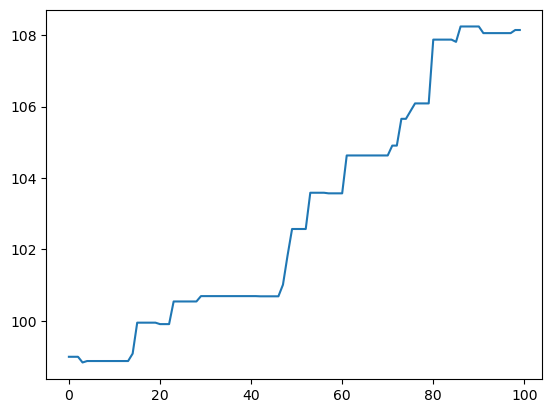

In [ ]:
T0 = 0.1 # Initial temperature cannot be very high or will erase greedy (good enough?) initialization 
Tf = 0.01 # 
niterations = 100000

m = 1
λ = 0.5
β = 1.0
η = 1.0

pairing = pairing_greedy.copy()
free_lecturers = free_lecturers_greedy.copy()


combined_pairing = np.concatenate((pairing[:, 1], pairing[:, 2],free_lecturers))
# Check for duplicates
has_duplicates = len(combined_pairing) != len(np.unique(combined_pairing))
if has_duplicates:
    print("There are duplicates in the greedy pairing")
else:
    print("There are NO duplicates in the greedy pairing")

print("Duplicates found:" if has_duplicates else "No duplicates found.")

def score(student,tutor,examiner): # score of a specific triplet, returns 3 scores (score1, score2, score3)
    # score1: function to maximize for perfect pairing -> L
    # score2: number of topics share among all individuals in the triplet
    # score3: number of topics common between examiner/tutor
    σS = students_list[student]
    φT = lecturers_list[tutor]
    φE = lecturers_list[examiner]
    τ = lecturers_prole[tutor][0]
    ε = lecturers_prole[examiner][1]
    #print("Proposed pairing: ",σS,φT,φE)
    #print("Products: ",np.sum(σS*φT),np.sum(σS*φT*φE) )
    #print("scores: ",np.sum(σS*φT*(1 + λ*φE)) + np.sum(β*φT*φE) + η*(τ+ε),  np.sum((σS>0)*φT*φE), np.sum(φT*φE))
    return np.sum(σS*φT*(1 + λ*φE)) + np.sum(β*φT*φE) + η*(τ+ε),  np.sum((σS>0)*φT*φE), np.sum(φT*φE) 

scores = np.array([score(s,t,e) for s,t,e in pairing],dtype=float) # scores of the initial pairings
# print("Initial Scores:", scores)

# pairings with lower scores will be prioritize to change. This can be done by introducing weights based on the score
rank_scores = len(scores) - np.argsort(np.argsort(scores[:,0])) # rank of scores
weights = 1 + (rank_scores -1)*(10-1)/(len(rank_scores)-1) # weight scores from 1 to 10
weights = weights / np.sum(weights) # normalize the weights
# print('weights =',weights)

p0 = 0.1
def update_weights(weights):
    rank_scores = len(scores) - np.argsort(np.argsort(scores[:,0])) # rank of scores
    weights = 1 + (rank_scores -1)*(10-1)/(len(rank_scores)-1) # weight scores from 1 to 10
    weights = weights / np.sum(weights) # normalize the weights
    

print("Starting score is: {}, with {} non-triplet commonalities, and {} non-buddies".format(
    np.sum(scores[:,0]),np.sum(scores[:,1] == 0), np.sum(scores[:,2] == 0)))        


def external_annealing(pairing,weights,scores,free_lecturers): 
    # attempt to introduce one of the non-used examiners
    new_lecturer = np.random.choice(free_lecturers)
    ipairing = np.random.choice(range(N_students),p=weights) # target pairing
    irole = 1+np.random.choice(range(2)) # examiner or tutor?
    busy_lecturer = pairing[ipairing,irole]
    
    L_before = score(* (pairing[ipairing]))[0]
    
    new_pairing = (pairing[ipairing]).copy()
    new_pairing[irole] = new_lecturer
    
    scores_after = score(*new_pairing)
    L_after = scores_after[0]
    
    
    if (L_after>L_before or np.exp((L_after-L_before)/T) > random.random()): # accept swap
        pairing[ipairing] = new_pairing
        free_lecturers.remove(new_lecturer)
        free_lecturers.append(busy_lecturer)
        scores[ipairing] = scores_after
        update_weights(weights)
        

def swap_annealing(pairing,weights,scores):
    # choose two lecturers to swap. First lecturers is chosed from a student with a probability inversely proportional to their score
    ipairing1 = np.random.choice(range(N_students), p=weights)
    ipairing2 = np.random.choice(range(N_students))

    if (ipairing1 != ipairing2):

        pairing1 = (pairing[ipairing1]).copy()
        pairing2 = (pairing[ipairing2]).copy()

        L_before = score(*pairing1)[0] + score(*pairing2)[0]

        # choose a kind of exchange at random:
        idx1 = 1+np.random.choice(range(2)) # examiner or tutor?
        idx2 = 1+np.random.choice(range(2)) # examiner or tutor?
        # print("\n idxs:",idx1,idx2)
        # print("ipairings:",ipairing1,ipairing2)
        # print("original pairings:", pairing1, pairing2)

        pairing2[idx1], pairing1[idx2] = pairing1[idx2], pairing2[idx1]
    
        # print("proposed pairings:", pairing1, pairing2)
    
        L_after = score(*pairing1)[0] + score(*pairing2)[0]
           
        if (L_after>L_before or np.exp((L_after-L_before)/T) > random.random()): # accept swap
            pairing[ipairing1] = pairing1[:]
            pairing[ipairing2] = pairing2[:]
            scores[ipairing1] = score(*pairing1)
            scores[ipairing2] = score(*pairing2)
            update_weights(weights)

    
    else: # same student getting examiner/tutor swapped
        
        pairing1 = (pairing[ipairing1]).copy()
        L_before = scores[ipairing1,0]
        pairing1[1], pairing1[2] = pairing1[2], pairing1[1]
        L_after = score(*pairing1)[0]

        if (L_after>L_before or np.exp((L_after-L_before)/T) > random.random()): # accept swap
            pairing[ipairing1] = pairing1[:]
            scores[ipairing1] = score(*pairing1)
            update_weights(weights)

        
    
    combined_pairing = np.concatenate((pairing[:, 1], pairing[:, 2],free_lecturers))
    # Check for duplicates
    has_duplicates = len(combined_pairing) != len(np.unique(combined_pairing))
    if has_duplicates:
        print("There are duplicates in the pairing")


    
    
        
# main annealing loop

T=T0
dT = (Tf/T0)**(1/niterations)
historyL = []


batch = niterations//100
for i in tqdm(range(niterations)):
    swap_annealing(pairing,weights,scores)
    external_annealing(pairing,weights,scores,free_lecturers)        
    T = T * dT
    if i//batch == 0:
        historyL.append(np.sum(scores[:,0]))
    
plt.plot(historyL)


print("Finished annealing!")
print("Final Score is: {}, with {} non-triplet commonalities, and {} non-buddies".format(np.sum(scores[:,0]),np.sum(scores[:,1] == 0), np.sum(scores[:,2] == 0)))        
        
        
pairing_df = [pd.concat([df_students_prefix.iloc[i], df_tutors_prefix.iloc[j], df_examiners_prefix.iloc[k]]) for i,j,k in pairing]
pairing_df = pd.DataFrame(pairing_df).reset_index(drop=True)
pairing_df['Score1'] = scores[:,0]
pairing_df['Score2'] = scores[:,1]
pairing_df['Score3'] = scores[:,2]
pairing_df.to_csv('annealed_pairing.csv', index=False)

        
    
    

In [22]:
scores

array([[21,  0,  1],
       [22,  0,  0],
       [21,  0,  0],
       [22,  0,  0],
       [21,  0,  0],
       [20,  0,  0],
       [20,  0,  0],
       [20,  0,  0],
       [20, 20, 20],
       [21,  0,  0],
       [21,  0,  0],
       [22,  0,  0],
       [21,  0,  0],
       [19,  0,  0],
       [20,  0,  0],
       [20,  0,  0],
       [21,  0,  0],
       [22,  0,  0],
       [21, 21, 21],
       [20,  0,  0],
       [21,  0,  0],
       [13,  0,  0],
       [13, 13, 13],
       [21, 21, 21],
       [20,  0,  0],
       [21,  0,  0],
       [20, 20, 20],
       [20,  0,  0],
       [20,  0,  0],
       [21,  0,  0],
       [21,  0,  0],
       [13,  0,  0],
       [21, 21, 21],
       [21,  0,  0]])